In [18]:
import numpy as np
from netCDF4 import Dataset

wind_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind\MERRA2_400.tavg3_3d_asm_Nv.20191227.nc4"
ds = Dataset(wind_path)

# Example: extracting surface or lowest layer
U = ds.variables['U'][:, 0, :, :]  # [time, lat, lon]
V = ds.variables['V'][:, 0, :, :]
T = ds.variables['T'][:, 0, :, :]
RH = ds.variables['RH'][:, 0, :, :]



In [19]:
wind_speed = np.sqrt(U**2 + V**2)  # shape: [time, lat, lon]
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]
times = ds.variables['time'][:]
from datetime import datetime, timedelta
import pandas as pd

base_time = datetime(2019, 12, 25)
timestamps = [base_time + timedelta(hours=int(t)) for t in times]  # adjust unit if needed

grid_coords = [(lat, lon) for lat in lats for lon in lons]
meteorological_rows = []

for t_idx, timestamp in enumerate(timestamps):
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            meteorological_rows.append({
                "datetime": timestamp,
                "lat": lat,
                "lon": lon,
                "wind_speed": float(wind_speed[t_idx, i, j]),
                "temp": float(T[t_idx, i, j]),
                "rh": float(RH[t_idx, i, j]),
            })
meteo_df = pd.DataFrame(meteorological_rows)


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_660\2257169610.py:4: RuntimeWarning: invalid value encountered in cast
  times = ds.variables['time'][:]
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_660\2257169610.py:4: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  times = ds.variables['time'][:]


In [20]:
# Assuming you already matched AOD and PM2.5 as `matched_df`
# Now join with meteorological features
from scipy.spatial import cKDTree

tree = cKDTree(meteo_df[['lat', 'lon']].values)

def add_meteorology(row):
    # filter for same time
    time_match = meteo_df[meteo_df['datetime'] == row['datetime']]
    if time_match.empty:
        return pd.Series([np.nan]*3, index=['wind_speed', 'temp', 'rh'])

    # find nearest grid point
    dist, idx = cKDTree(time_match[['lat', 'lon']].values).query([row['lat'], row['lon']])
    match = time_match.iloc[idx]
    return pd.Series([match['wind_speed'], match['temp'], match['rh']],
                     index=['wind_speed', 'temp', 'rh'])

enriched_df = matched_df.copy()
enriched_df[['wind_speed', 'temp', 'rh']] = enriched_df.apply(add_meteorology, axis=1)


In [21]:
import pandas as pd
from netCDF4 import Dataset
csv_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind\2019_All_sites_air_quality.csv"
df = pd.read_csv(csv_path, usecols=[
    "sample_point_id", "sp_name", "latitude", "longitude",
    "sample_datetime", "param_name", "value", "param_short_name"
])

# Convert date and filter
df['sample_datetime'] = pd.to_datetime(df['sample_datetime'], dayfirst=True)
filtered_df = df[(df['sample_datetime'] >= '2019-12-25') & 
                 (df['sample_datetime'] < '2019-12-31')]

# Filter PM2.5 only
pm25_df = filtered_df[filtered_df['param_short_name'] == 'PM2.5']
pm25_df = pm25_df.dropna(subset=['latitude', 'longitude', 'value'])
pm25_df = pm25_df.copy()
pm25_df['sample_datetime_3hr'] = pm25_df['sample_datetime'].dt.floor('3h')
print(pm25_df)


        sample_point_id    sp_name   latitude   longitude     sample_datetime  \
147780            10219  Churchill -38.304314  146.414932 2019-12-25 00:00:00   
147781            10219  Churchill -38.304314  146.414932 2019-12-25 01:00:00   
147782            10219  Churchill -38.304314  146.414932 2019-12-25 02:00:00   
147783            10219  Churchill -38.304314  146.414932 2019-12-25 03:00:00   
147784            10219  Churchill -38.304314  146.414932 2019-12-25 04:00:00   
...                 ...        ...        ...         ...                 ...   
732089            10011  Traralgon -38.194283  146.531464 2019-12-30 19:00:00   
732100            10011  Traralgon -38.194283  146.531464 2019-12-30 20:00:00   
732111            10011  Traralgon -38.194283  146.531464 2019-12-30 21:00:00   
732122            10011  Traralgon -38.194283  146.531464 2019-12-30 22:00:00   
732133            10011  Traralgon -38.194283  146.531464 2019-12-30 23:00:00   

                         pa

In [4]:
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191225.nc4"
dataset = Dataset(file_path, 'r')

In [25]:

import pandas as pd
import numpy as np
from netCDF4 import Dataset
from scipy.spatial import cKDTree
from datetime import datetime, timedelta

# === Load AOD data ===
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191225.nc4"
dataset = Dataset(file_path, 'r')

aod_data = dataset['AODANA'][:]     # shape (8, 361, 576)
lats = dataset['lat'][:]            # shape (361,)
lons = dataset['lon'][:]            # shape (576,)
times = dataset['time'][:]          # [0, 180, ...] in minutes since 2019-10-01
base_time = datetime(2019, 12, 25)
timestamps = [base_time + timedelta(minutes=int(t)) for t in times]
# Round AOD timestamps to exactly the same string format
aod_times_df = pd.DataFrame({'aod_time': timestamps})
aod_times_df['key'] = aod_times_df['aod_time'].dt.strftime('%Y-%m-%d %H:%M')

# === Precompute AOD grid coordinates and flatten ===
lon_grid, lat_grid = np.meshgrid(lons, lats)
grid_coords = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])  # shape (361*576, 2)

# Build KDTree from grid coordinates (lat, lon)
tree = cKDTree(grid_coords)

print(tree)
test_coord = [-37.8, 146.4]  # [lat, lon]
dist, idx = tree.query(test_coord)
nearest_lat, nearest_lon = grid_coords[idx]
print(f"Nearest grid point to {test_coord}:")
print(f"Lat: {nearest_lat}, Lon: {nearest_lon}")
print(f"Distance: {dist:.4f} degrees")
print("Available latitude range:", lats.min(), "to", lats.max())
print("Available longitude range:", lons.min(), "to", lons.max())


Nearest grid point to [-37.8, 146.4]:
Lat: -38.0, Lon: 146.25
Distance: 0.2500 degrees
Available latitude range: -90.0 to 90.0
Available longitude range: -180.0 to 179.375


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_660\3082109513.py:14: RuntimeWarning: invalid value encountered in cast
  times = dataset['time'][:]          # [0, 180, ...] in minutes since 2019-10-01
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_660\3082109513.py:14: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  times = dataset['time'][:]          # [0, 180, ...] in minutes since 2019-10-01


In [26]:
# === Load PM2.5 CSV ===
csv_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind\2019_All_sites_air_quality.csv"
df = pd.read_csv(csv_path, usecols=[
    "sample_point_id", "sp_name", "latitude", "longitude",
    "sample_datetime", "param_name", "value", "param_short_name"
])
df['sample_datetime'] = pd.to_datetime(df['sample_datetime'], dayfirst=True)

# Filter to Dec 25–30 and PM2.5
df = df[(df['sample_datetime'] >= '2019-12-25') & (df['sample_datetime'] < '2019-12-31')]
pm25_df = df[df['param_short_name'] == 'PM2.5'].dropna(subset=['latitude', 'longitude', 'value']).copy()
pm25_df['sample_datetime_3hr'] = pm25_df['sample_datetime'].dt.floor('3h')
# Create matching key for PM2.5
pm25_df['key'] = pm25_df['sample_datetime_3hr'].dt.strftime('%Y-%m-%d %H:%M')
print(pm25_df)


        sample_point_id    sp_name   latitude   longitude     sample_datetime  \
147780            10219  Churchill -38.304314  146.414932 2019-12-25 00:00:00   
147781            10219  Churchill -38.304314  146.414932 2019-12-25 01:00:00   
147782            10219  Churchill -38.304314  146.414932 2019-12-25 02:00:00   
147783            10219  Churchill -38.304314  146.414932 2019-12-25 03:00:00   
147784            10219  Churchill -38.304314  146.414932 2019-12-25 04:00:00   
...                 ...        ...        ...         ...                 ...   
732089            10011  Traralgon -38.194283  146.531464 2019-12-30 19:00:00   
732100            10011  Traralgon -38.194283  146.531464 2019-12-30 20:00:00   
732111            10011  Traralgon -38.194283  146.531464 2019-12-30 21:00:00   
732122            10011  Traralgon -38.194283  146.531464 2019-12-30 22:00:00   
732133            10011  Traralgon -38.194283  146.531464 2019-12-30 23:00:00   

                         pa

In [40]:
from scipy.spatial import cKDTree

# Create wind grid KDTree (same structure as AOD)
lon_grid_wind, lat_grid_wind = np.meshgrid(lons, lats)
wind_coords = np.column_stack([lat_grid_wind.ravel(), lon_grid_wind.ravel()])
wind_tree = cKDTree(wind_coords)

# Generate wind datetime array if not already
wind_times = ds.variables['time'][:]
wind_base_time = datetime(2019, 12, 27)  # Adjust based on NetCDF metadata
wind_timestamps = [wind_base_time + timedelta(hours=int(t)) for t in wind_times]

matched_data = []

# Join AOD + PM2.5
merged_df = pm25_df.merge(aod_times_df, on='key')

for _, row in merged_df.iterrows():
    point = [row['latitude'], row['longitude']]
    
    # === AOD ===
    dist, idx = tree.query(point)
    aod_time = row['aod_time']
    t_idx = timestamps.index(aod_time)
    aod_value = aod_data[t_idx].ravel()[idx]

    # === WIND ===
    # Match wind timestamp (closest)
    wind_idx = np.argmin([abs((aod_time - wt).total_seconds()) for wt in wind_timestamps])
    wind_U = U[wind_idx].ravel()[idx]
    wind_V = V[wind_idx].ravel()[idx]
    wind_speed = np.sqrt(wind_U**2 + wind_V**2)
    temp = T[wind_idx].ravel()[idx]
    rh = RH[wind_idx].ravel()[idx]

    matched_data.append({
        'datetime': aod_time,
        'station': row['sp_name'],
        'lat': row['latitude'],
        'lon': row['longitude'],
        'PM2.5': row['value'],
        'AOD': aod_value,
        'U': wind_U,
        'V': wind_V,
        'wind_speed': wind_speed,
        'temp': temp,
        'rh': rh
    })

matched_df = pd.DataFrame(matched_data)
print(matched_df.head())


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_660\1015106486.py:9: RuntimeWarning: invalid value encountered in cast
  wind_times = ds.variables['time'][:]
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_660\1015106486.py:9: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  wind_times = ds.variables['time'][:]


             datetime    station        lat         lon  PM2.5       AOD  \
0 2019-12-25 00:00:00  Churchill -38.304314  146.414932    2.9  0.176619   
1 2019-12-25 00:00:00  Churchill -38.304314  146.414932   -0.9  0.176619   
2 2019-12-25 00:00:00  Churchill -38.304314  146.414932    0.0  0.176619   
3 2019-12-25 03:00:00  Churchill -38.304314  146.414932    2.4  0.143120   
4 2019-12-25 03:00:00  Churchill -38.304314  146.414932    3.2  0.143120   

           U         V  wind_speed        temp        rh  
0 -28.476816  0.724579   28.486033  194.408295  0.000069  
1 -28.476816  0.724579   28.486033  194.408295  0.000069  
2 -28.476816  0.724579   28.486033  194.408295  0.000069  
3 -28.476816  0.724579   28.486033  194.408295  0.000069  
4 -28.476816  0.724579   28.486033  194.408295  0.000069  


In [41]:
print(matched_df.head(20))


              datetime    station        lat         lon      PM2.5       AOD  \
0  2019-12-25 00:00:00  Churchill -38.304314  146.414932   2.900000  0.176619   
1  2019-12-25 00:00:00  Churchill -38.304314  146.414932  -0.900000  0.176619   
2  2019-12-25 00:00:00  Churchill -38.304314  146.414932   0.000000  0.176619   
3  2019-12-25 03:00:00  Churchill -38.304314  146.414932   2.400000  0.143120   
4  2019-12-25 03:00:00  Churchill -38.304314  146.414932   3.200000  0.143120   
5  2019-12-25 03:00:00  Churchill -38.304314  146.414932   4.300000  0.143120   
6  2019-12-25 06:00:00  Churchill -38.304314  146.414932   5.200000  0.134794   
7  2019-12-25 06:00:00  Churchill -38.304314  146.414932   3.800000  0.134794   
8  2019-12-25 06:00:00  Churchill -38.304314  146.414932   2.800000  0.134794   
9  2019-12-25 09:00:00  Churchill -38.304314  146.414932  -0.300000  0.149350   
10 2019-12-25 09:00:00  Churchill -38.304314  146.414932   2.100000  0.149350   
11 2019-12-25 09:00:00  Chur

In [42]:
from sklearn.model_selection import train_test_split

# Features and target
features = ['AOD', 'lat', 'lon', 'U', 'V', 'wind_speed', 'temp', 'rh']
X = matched_df[features].dropna()
y = matched_df.loc[X.index, 'PM2.5']

# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 9.49
R²: 0.69


C:\Users\Nur Izfarwiza\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


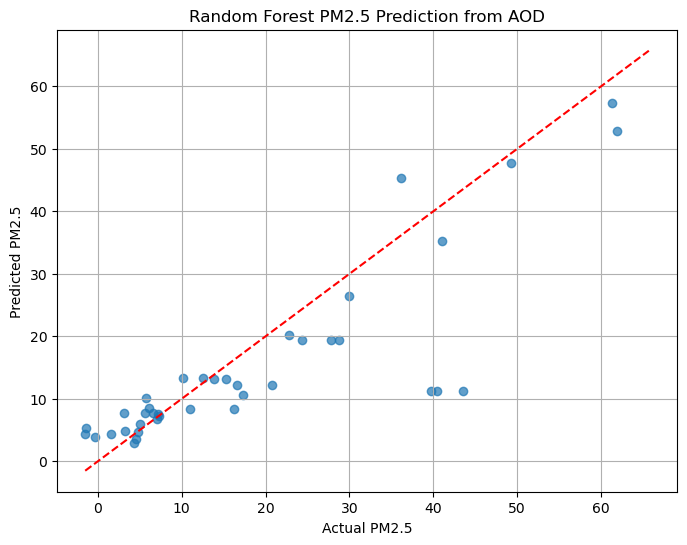

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Random Forest PM2.5 Prediction from AOD")
plt.grid(True)
plt.show()


C:\Users\Nur Izfarwiza\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\Nur Izfarwiza\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\Nur Izfarwiza\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


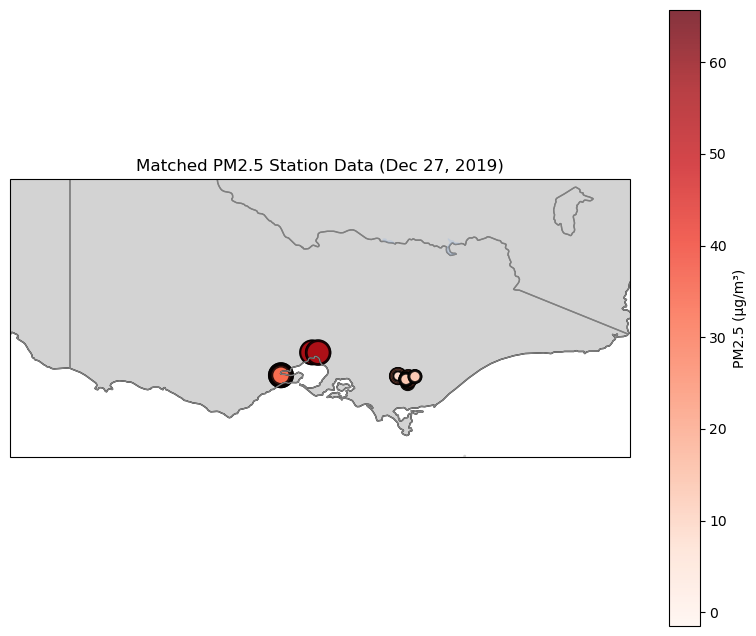

In [46]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Filter out invalid PM2.5 rows (NaN or negative)
plot_df = matched_df[(matched_df['PM2.5'].notna()) & (matched_df['PM2.5'] > 0)].copy()

# Optional: set a minimum marker size to avoid very small points
plot_df['size'] = np.sqrt(plot_df['PM2.5']) * 10


# Create a figure with PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent to focus on Victoria, Australia
ax.set_extent([140, 150, -39.5, -35])  # [lon_min, lon_max, lat_min, lat_max]

# Add basic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.LAKES, alpha=0.3)

# Plot PM2.5 as scatter points
scatter = ax.scatter(
    matched_df['lon'], matched_df['lat'],
    c=matched_df['PM2.5'], cmap='Reds', s=matched_df['PM2.5'] * 5,
    alpha=0.8, edgecolor='black', transform=ccrs.PlateCarree()
)

# Colorbar
plt.colorbar(scatter, ax=ax, orientation='vertical', label='PM2.5 (µg/m³)')

plt.title("Matched PM2.5 Station Data (Dec 27, 2019)")
plt.show()


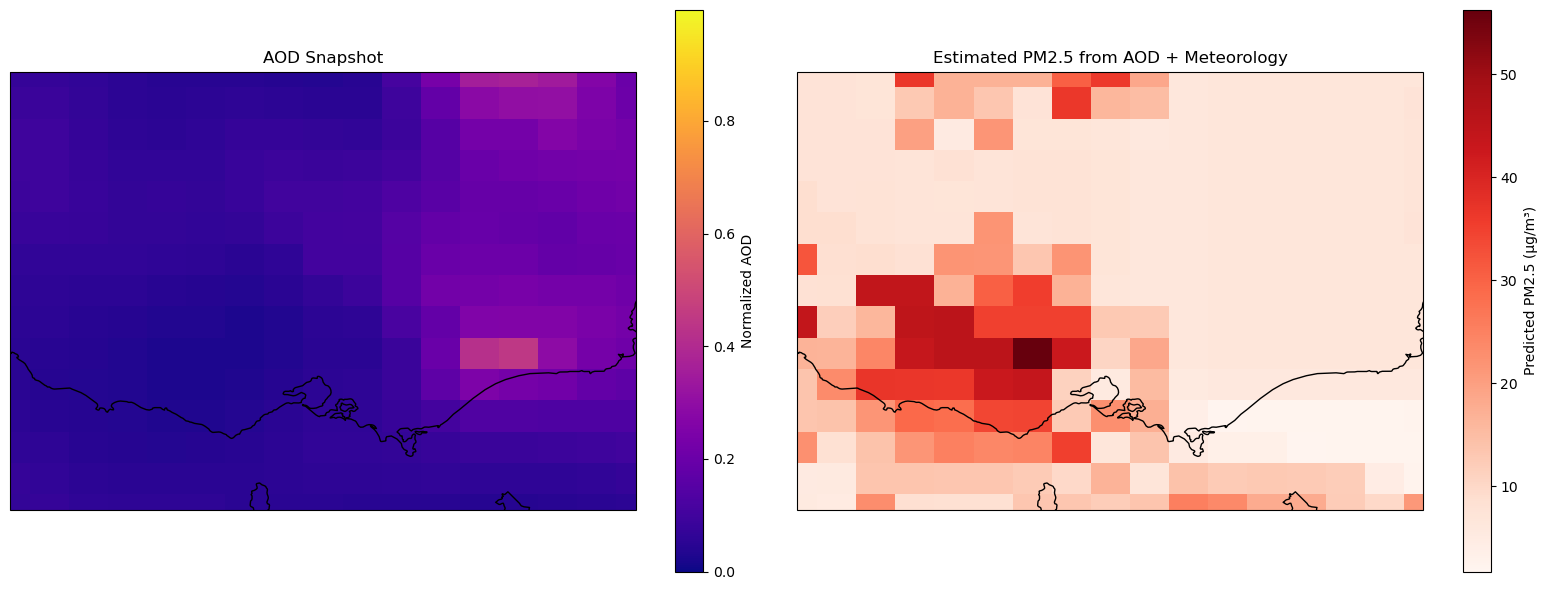

In [49]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === AOD Setup ===
aod_grid = aod_data[0]  # First time step (e.g., 00:00)
aod_norm = (aod_grid - np.min(aod_grid)) / (np.max(aod_grid) + 1e-6)

# === Predicted PM2.5 Grid ===
# Assume you already trained your model:
# We'll apply it to all grid points with available features (AOD, U, V, wind_speed, temp, rh)

# Create DataFrame for full grid prediction
grid_df = pd.DataFrame({
    'AOD': aod_grid.ravel(),
    'lat': lat_grid.ravel(),
    'lon': lon_grid.ravel(),
    'U': U[0].ravel(),
    'V': V[0].ravel(),
    'wind_speed': np.sqrt(U[0]**2 + V[0]**2).ravel(),
    'temp': T[0].ravel(),
    'rh': RH[0].ravel()
})

# Drop any NaNs before prediction
grid_df_clean = grid_df.dropna()
grid_features = grid_df_clean[['AOD', 'lat', 'lon', 'U', 'V', 'wind_speed', 'temp', 'rh']]
predicted_pm25 = model.predict(grid_features)

# === Map grid points back into 2D shape ===
pm25_grid = np.full(lat_grid.shape, np.nan)
valid_idx = grid_df_clean.index
pm25_grid = pm25_grid.ravel()
pm25_grid[valid_idx] = predicted_pm25
pm25_grid = pm25_grid.reshape(lat_grid.shape)

# === Set up Cartopy Plots ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# === AOD Plot ===
ax1 = axes[0]
ax1.set_title("AOD Snapshot")
ax1.set_extent([140, 150, -40, -33])
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
cf1 = ax1.pcolormesh(lon_grid, lat_grid, aod_norm, cmap='plasma', shading='auto')
fig.colorbar(cf1, ax=ax1, orientation='vertical', label='Normalized AOD')

# === PM2.5 Prediction Plot ===
ax2 = axes[1]
ax2.set_title("Estimated PM2.5 from AOD + Meteorology")
ax2.set_extent([140, 150, -40, -33])
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
cf2 = ax2.pcolormesh(lon_grid, lat_grid, pm25_grid, cmap='Reds', shading='auto')
fig.colorbar(cf2, ax=ax2, orientation='vertical', label='Predicted PM2.5 (µg/m³)')

plt.tight_layout()
plt.show()
